# PSF Experiment Notebook - Galaxies w/o shape noise

This notebook contains the basic PSF test

2. Can AutoMetaCal perform better than ngmix by using the input PSFs for reconv? Using the PSF response...


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import galsim
import ngmix

from multiprocessing import Pool, freeze_support, cpu_count

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Test setup

In [3]:
#global values
fixnoise = True
batch_size=1200
scale= .2
stamp_size = 51
rng = np.random.RandomState(31415)
real_shear = [0.01,0.0]
noise_level = 1e-4

## Data

In [4]:
#dataset
data= tfds.load('simple/small_100k_noshear')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

Display a range of galaxy models:

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
labels = onebatch['label'] 

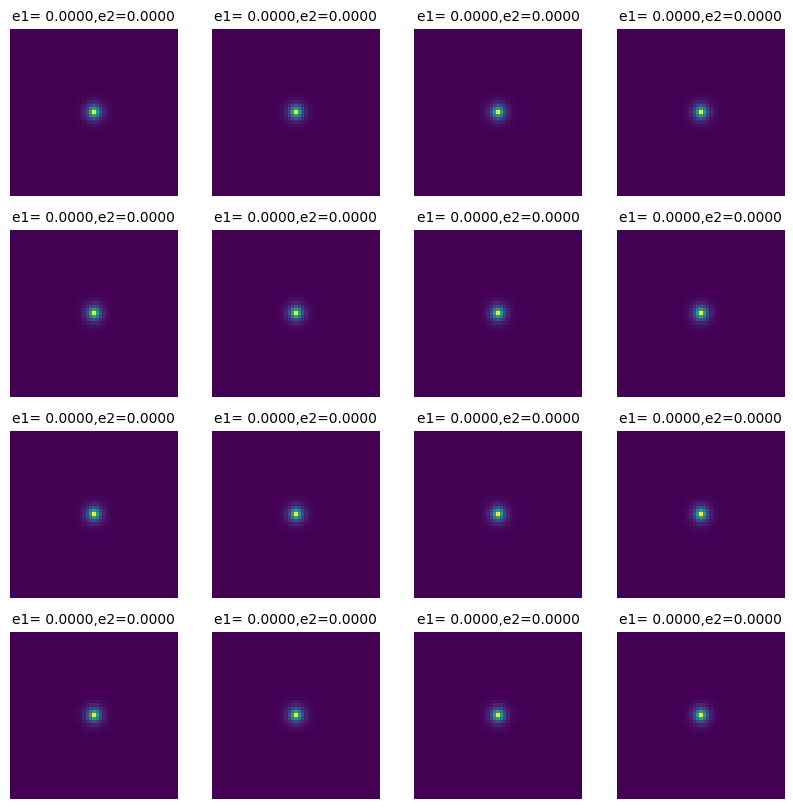

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"e1= {labels[i][0]:.4f},e2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

We transform these models by:
1. Adding a constant shear
3. Convolving with a PSF
2. Adding some noise

Both 1 and 2 are taken care by the noiseless_real_mcal_image function developed for the LearnR project.

In [7]:
#create 1 batch of observed images
psf_fwhm = 0.7
psf = galsim.Moffat(beta=5.0, fwhm=psf_fwhm).shear(g1=.01,g2=.0)
psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
psf_images = tf.repeat(psf_image,batch_size,axis=0)

gal_images=amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([real_shear],
                                        len(onebatch['gal_model']),axis=0))

noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])
gal_images += noise
psf_noise = np.random.normal(scale=noise_level,size=[batch_size,51,51])/1e3
psf_images += psf_noise

wt = tf.reduce_mean(1.0/(noise)**2,axis=0).numpy()
psf_wt = tf.reduce_mean(1.0/(psf_noise)**2,axis=0).numpy()

In [8]:
amc.noiseless_real_mcal_image?

Signature: amc.noiseless_real_mcal_image(gal_images, psf_images, g)
Docstring:
Shear a galaxy model and convolve with a PSF.
Args: 
  gal_images: tf.Tensor or np.array
    (batch_size, N, N ) image of models of galaxies
  psf_images: tf.Tensor or np.array
    (batch_size, N, N ) image of psf model
  g: tf.Tensor or np.array
  [batch_size, 2] input shear
Returns:
  img: tf.Tensor
    tf tensor containing image of galaxy after deconvolution by psf_deconv, 
    shearing by g, and reconvolution with reconvolution_psf_image.
File:      ~/github/autometacal/autometacal/python/utils.py
Type:      function


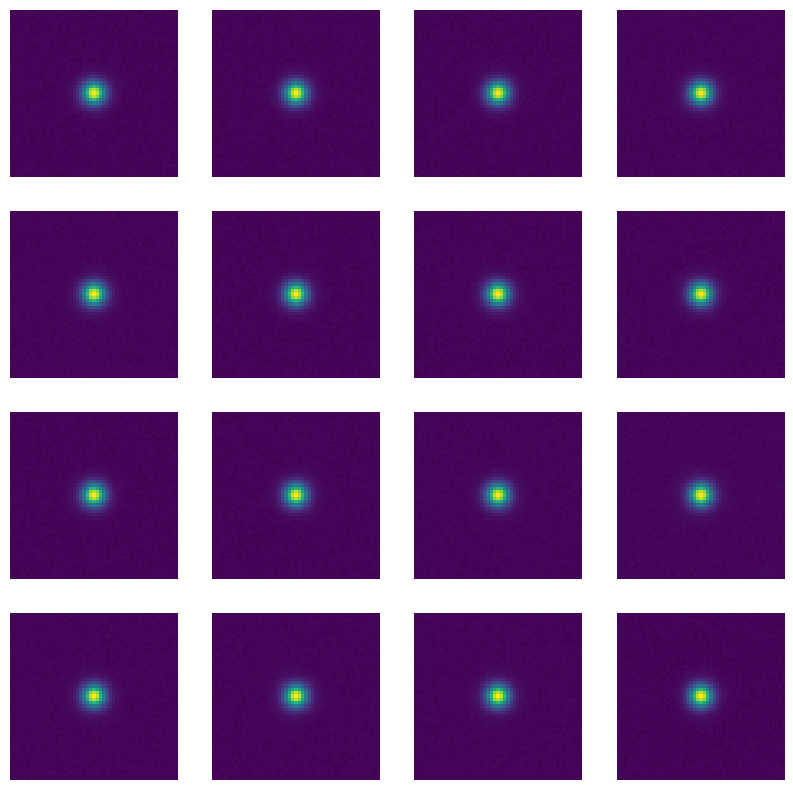

In [9]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin= 'lower')
  axis('off')

## One Batch Test!

## Model Fitting

In [10]:
def get_metacal_response_ngmix(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['g'][0], resdict['noshear']['g'][1]])
  g1p = np.array([resdict['1p']['g'][0], resdict['1p']['g'][1]])
  g1m = np.array([resdict['1m']['g'][0], resdict['1m']['g'][1]])
  g2p = np.array([resdict['2p']['g'][0], resdict['2p']['g'][1]])
  g2m = np.array([resdict['2m']['g'][0], resdict['2m']['g'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
  
  if '1p_psf' in resdict.keys():
    #PSF
    g1p_psf = np.array([resdict['1p_psf']['g'][0], resdict['1p_psf']['g'][1]])
    g1m_psf = np.array([resdict['1m_psf']['g'][0], resdict['1m_psf']['g'][1]])
    g2p_psf = np.array([resdict['2p_psf']['g'][0], resdict['2p_psf']['g'][1]])
    g2m_psf = np.array([resdict['2m_psf']['g'][0], resdict['2m_psf']['g'][1]])    

    R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
    R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
    R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
    R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  

    ellip_dict = {
      'noshear':g0s,
      '1p':g1p,
      '1m':g1m,
      '2p':g2p,
      '2m':g2m,
      '1p_psf':g1p_psf,
      '1m_psf':g1m_psf,
      '2p_psf':g2p_psf,
      '2m_psf':g2m_psf,    
    } 

    Rpsf = np.array(
      [[R11_psf,R12_psf],
       [R21_psf,R22_psf]])
    return ellip_dict, R, Rpsf
  else:
    ellip_dict = {
      'noshear':g0s,
      '1p':g1p,
      '1m':g1m,
      '2p':g2p,
      '2m':g2m, 
    }
    return ellip_dict, R   

## Set ngmix jacobian

In [11]:
#set up jacobian
jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

### Set priors for ngmix

In [12]:
T_range = [-1.0, 10.]
F_range = [-1.0, 2.]

g_prior = ngmix.priors.GPriorBA(sigma=0.1, rng=rng)
cen_prior = ngmix.priors.CenPrior(
    cen1=0, cen2=0, sigma1=scale, sigma2=scale, rng=rng,
)
T_prior = ngmix.priors.FlatPrior(minval=T_range[0], maxval=T_range[1], rng=rng)
F_prior = ngmix.priors.FlatPrior(minval=F_range[0], maxval=F_range[1], rng=rng)

prior = ngmix.joint_prior.PriorSimpleSep(
    cen_prior=cen_prior,
    g_prior=g_prior,
    T_prior=T_prior,
    F_prior=F_prior,
)

### Set fitters/runners for ngmix

In [13]:
# fit using the levenberg marquards algorithm
fitter = ngmix.fitting.Fitter(model='exp', prior=prior)
# make parameter guesses based on a psf flux and a rough T
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
    rng=rng,
    T=.25,
    prior=prior,
)

# psf fitting with coelliptical gaussians
psf_ngauss = 1
psf_fitter = ngmix.fitting.CoellipFitter(ngauss=psf_ngauss)
# special guesser for coelliptical gaussians
psf_guesser = ngmix.guessers.CoellipPSFGuesser(rng=rng, ngauss=psf_ngauss)

# this runs the fitter. We set ntry=2 to retry the fit if it fails
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=10,
)
runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=10,
)

## Set ngmix bootstrapper

In [14]:
METACAL_TYPES = ['noshear',
                 '1p','1m','2p','2m','1p_psf','1m_psf','2p_psf','2m_psf']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='dilate',
  types=METACAL_TYPES,
  fixnoise=fixnoise,
)

In [15]:
T_range = [-1.0, 10.]
F_range = [-1.0, 2.]

g_prior = ngmix.priors.GPriorBA(sigma=0.1, rng=rng)
cen_prior = ngmix.priors.CenPrior(
    cen1=0, cen2=0, sigma1=scale, sigma2=scale, rng=rng,
)
T_prior = ngmix.priors.FlatPrior(minval=T_range[0], maxval=T_range[1], rng=rng)
F_prior = ngmix.priors.FlatPrior(minval=F_range[0], maxval=F_range[1], rng=rng)

prior = ngmix.joint_prior.PriorSimpleSep(
    cen_prior=cen_prior,
    g_prior=g_prior,
    T_prior=T_prior,
    F_prior=F_prior,
)

# fit using the levenberg marquards algorithm
fitter = ngmix.fitting.Fitter(model='exp', prior=prior)
# make parameter guesses based on a psf flux and a rough T
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
    rng=rng,
    T=.25,
    prior=prior,
)

# psf fitting with coelliptical gaussians
psf_ngauss = 1
psf_fitter = ngmix.fitting.CoellipFitter(ngauss=psf_ngauss)
# special guesser for coelliptical gaussians
psf_guesser = ngmix.guessers.CoellipPSFGuesser(rng=rng, ngauss=psf_ngauss)

# this runs the fitter. We set ntry=2 to retry the fit if it fails
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=10,
)
runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=10,
)

# this bootstraps the process, first fitting psfs then the object
boot = ngmix.bootstrap.Bootstrapper(
    runner=runner,
    psf_runner=psf_runner,
)

METACAL_TYPES = ['noshear',
                 '1p','1m','2p','2m',]#'1p_psf','1m_psf','2p_psf','2m_psf']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=METACAL_TYPES,
  fixnoise=fixnoise,
)

## Run ngmix

In [16]:
#parallelization wrappre
def ngmix_runner(im_psf):
  im, psf_im = im_psf
  psf_obs = ngmix.Observation(
    psf_im,
    weight=psf_wt,
    jacobian=psf_jacobian,
  )
  
  obs = ngmix.Observation(
    im,
    jacobian=jacobian,
    weight=wt,
    psf=psf_obs,
  )
  
  #get moment ellipticities
  resdict, obsdict = boot.go(obs)
  e_ngmix, R_ngmix,  = get_metacal_response_ngmix(resdict)
  
  return e_ngmix['noshear'], R_ngmix

In [17]:
ims_psfs = zip([gal_images.numpy()[i] for i in range(len(gal_images))],
               [psf_images.numpy()[i] for i in range(len(gal_images))])

In [18]:
t = time.time()
pool = Pool(cpu_count()//2)
results = pool.map(ngmix_runner, ims_psfs)
pool.close()
print(f"Finished in: {time.time()-t} s.")

Finished in: 20.768118858337402 s.


In [19]:
ellips = array([result[0] for result in results])
R_ngmix = array([result[1] for result in results])

In [20]:
R_ngmix

array([[[ 1.03116581,  0.02171386],
        [ 0.08118563,  1.00455684]],

       [[ 1.02636543,  0.0246648 ],
        [ 0.09498672,  0.93779917]],

       [[ 1.00537452, -0.03770325],
        [ 0.09303771,  1.003954  ]],

       ...,

       [[ 0.96697194,  0.04377098],
        [-0.083237  ,  1.08208981]],

       [[ 1.0526799 ,  0.01889685],
        [ 0.03319499,  1.02205137]],

       [[ 1.00087786,  0.02864579],
        [-0.16687973,  1.02886866]]])

In [21]:
calibrated_shear= mean(linalg.inv(R_ngmix),axis=0) @ mean(ellips,axis=0)
calibrated_shear

array([0.01060825, 0.007244  ])

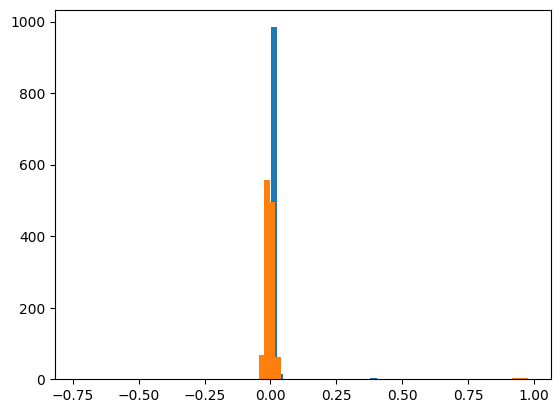

In [22]:
hist(ellips[:,0],bins=50);
hist(ellips[:,1],bins=50);

## AutoMetaCal

### New functions with PSF response

In [23]:
def generate_mcal_image(gal_images,
                        psf_images,
                        reconvolution_psf_image,
                        g, gp,
                        padfactor=3):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)  
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)  
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  
  #Get batch info
  batch_size, nx, ny = gal_images.get_shape().as_list()  
      
  #add pads in real space
  fact = (padfactor - 1)//2 #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
    
  padded_gal_images = tf.pad(gal_images,paddings)
  padded_psf_images = tf.pad(psf_images,paddings)
  padded_reconvolution_psf_image = tf.pad(reconvolution_psf_image,paddings)
    
  #Convert galaxy images to k space
  im_shift = tf.signal.ifftshift(padded_gal_images,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, tf.complex64)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  
  #Convert psf images to k space  
  psf_complex = tf.cast(padded_psf_images, tf.complex64)
  psf_fft = tf.signal.fft2d(psf_complex)
  psf_fft_abs = tf.abs(psf_fft)
  psf_fft_abs_complex = tf.cast(psf_fft_abs,tf.complex64)
  kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  #Convert reconvolution psf image to k space 
  rpsf_complex = tf.cast(padded_reconvolution_psf_image, tf.complex64)
  rpsf_fft =  tf.signal.fft2d(rpsf_complex)
  rpsf_fft_abs = tf.abs(rpsf_fft)
  psf_fft_abs_complex = tf.cast(rpsf_fft_abs,tf.complex64)
  krpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  # Compute Fourier mask for high frequencies
  # careful, this is not exactly the correct formula for fftfreq
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,padfactor*nx),
                       tf.linspace(-0.5,0.5,padfactor*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)
  
  # Deconvolve image from input PSF
  im_deconv = imk * ( (1./(kpsf+1e-10))*mask)

  # Apply shear to the  deconv image
  im_sheared = gf.shear(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]  

  # Apply shear to the  kpsf image
  kpsf_sheared = gf.shear(tf.expand_dims(krpsf,-1), gp[...,0], gp[...,1])[...,0]    
  
  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * kpsf_sheared * mask))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  return img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]




In [24]:
def get_metacal_response(gal_images,
                         psf_images,
                         reconvolution_psf_image,
                         method):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gs = tf.zeros([batch_size, 4])
  epsf = method(reconvolution_psf_image)
  with tf.GradientTape() as tape:
    tape.watch(gs)
    # Measure ellipticity under metacal
    e = method(generate_mcal_image(gal_images,
                                   psf_images,
                                   psf_images,
                                   gs[:,0:2],gs[:,2:4]))
    
  # Compute response matrix

  Rs = tape.batch_jacobian(e, gs)
  R, Rpsf = Rs[...,0:2], Rs[...,2:4]
  return e, epsf, R, Rpsf

In [25]:
#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return get_metacal_response(gal_images, psf_images,psf_images,method)